In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import math
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
from geopy.geocoders import ArcGIS
import folium
 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Shack Labs/DS - Assignment Part 1 data set.xlsx")
print(df.shape)

(414, 9)


In [4]:
df.head()

Transaction date  House Age  Distance from nearest Metro station (km)  \
0       2012.916667       32.0                                  84.87882   
1       2012.916667       19.5                                 306.59470   
2       2013.583333       13.3                                 561.98450   
3       2013.500000       13.3                                 561.98450   
4       2012.833333        5.0                                 390.56840   

   Number of convenience stores  latitude  longitude  Number of bedrooms  \
0                            10  24.98298  121.54024                   1   
1                             9  24.98034  121.53951                   2   
2                             5  24.98746  121.54391                   3   
3                             5  24.98746  121.54391                   2   
4                             5  24.97937  121.54245                   1   

   House size (sqft)  House price of unit area  
0                575                      37.9  
1               1240                      42.2  
2               1060                      47.3  
3                875                      54.8  
4                491                      43.1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Transaction date                          414 non-null    float64
 1   House Age                                 414 non-null    float64
 2   Distance from nearest Metro station (km)  414 non-null    float64
 3   Number of convenience stores              414 non-null    int64  
 4   latitude                                  414 non-null    float64
 5   longitude                                 414 non-null    float64
 6   Number of bedrooms                        414 non-null    int64  
 7   House size (sqft)                         414 non-null    int64  
 8   House price of unit area                  414 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 29.2 KB


## Feature Engineering

In [6]:
def extract_month(tran_date):
  month = 12 * (tran_date - math.floor(tran_date))
  month = math.floor(month)
  return month

In [7]:
dates = df['Transaction date'].unique()
# [12*(i - math.floor(i)) for i in dates]
list(map(extract_month, dates))

[11, 6, 6, 9, 8, 5, 0, 3, 3, 9, 0, 2]

In [8]:
# Feature Engineering - year and month of purchase and Total price of the house
df['Transaction date'].unique()
df['year'] = list(map(math.floor, df['Transaction date']))
df['month'] = list(map(extract_month, df['Transaction date']))
df['price'] = df['House size (sqft)']*df['House price of unit area']
df.head()

Transaction date  House Age  Distance from nearest Metro station (km)  \
0       2012.916667       32.0                                  84.87882   
1       2012.916667       19.5                                 306.59470   
2       2013.583333       13.3                                 561.98450   
3       2013.500000       13.3                                 561.98450   
4       2012.833333        5.0                                 390.56840   

   Number of convenience stores  latitude  longitude  Number of bedrooms  \
0                            10  24.98298  121.54024                   1   
1                             9  24.98034  121.53951                   2   
2                             5  24.98746  121.54391                   3   
3                             5  24.98746  121.54391                   2   
4                             5  24.97937  121.54245                   1   

   House size (sqft)  House price of unit area  year  month    price  
0                575                      37.9  2012     11  21792.5  
1               1240                      42.2  2012     11  52328.0  
2               1060                      47.3  2013      6  50138.0  
3                875                      54.8  2013      6  47950.0  
4                491                      43.1  2012      9  21162.1

## Plots and Inferences

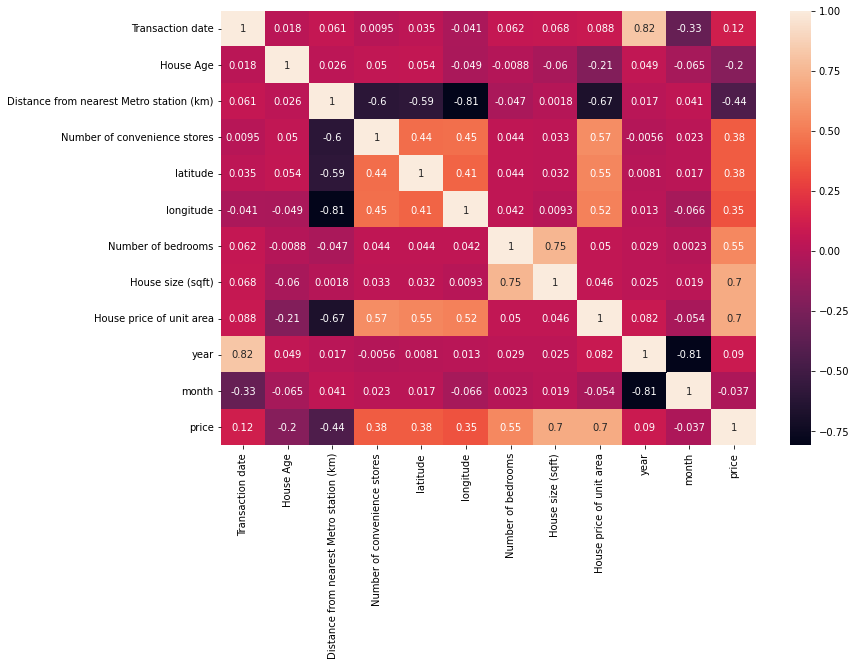

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)

From the heatmap it is clear that, distance_from_metro_station has *inverse relation* with house_price_of_unit_area, number_of_convenience_store, latitude, longitude.

house_price_of_unit_area has *slight correlation* with number_of_convenience_stores, latitude, longitude.

Though house_price_per_unit_area dont have any correlation with number_of_bedrooms, Total price have slight correlation with number of bedrooms.

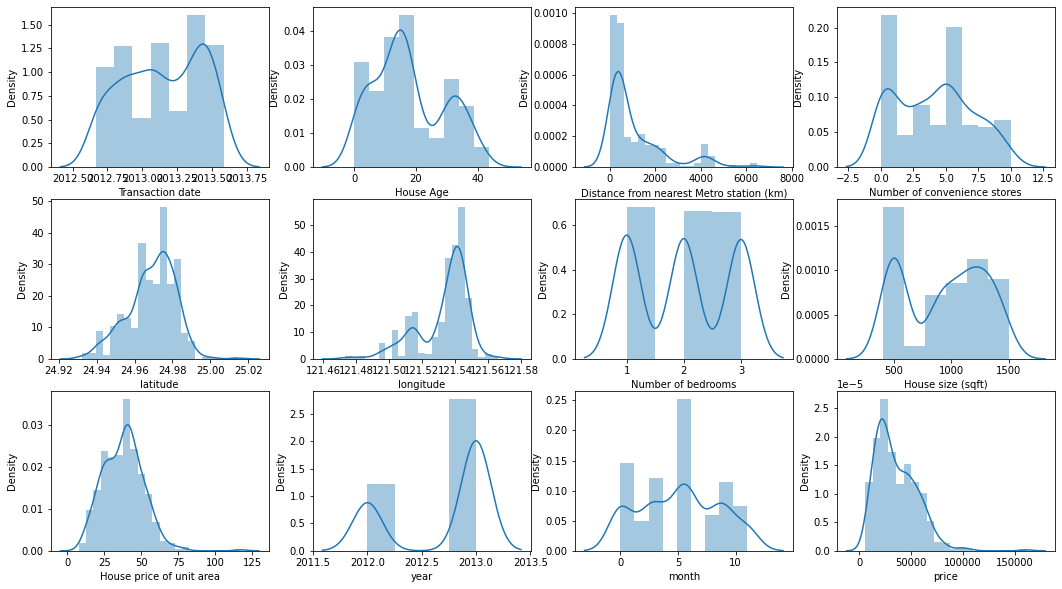

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(18, 10))
for i, col in enumerate(df.columns):
  sns.distplot(df[col], kde=True, ax=ax[int(i/4)][int(i%4)])

In [11]:
def multi_scatplot(feature):
  fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
  for i, col in enumerate(df.columns):
    if col == feature:
      sns.scatterplot(x=feature, y=col, data=df, hue='House price of unit area', ax=ax[int(i/4)][int(i%4)])
    else:
      sns.scatterplot(x=feature, y=col, data=df, hue='House price of unit area', ax=ax[int(i/4)][int(i%4)])
      ax[int(i/4)][int(i%4)].legend([])

In [12]:
def multi_lineplot(feature, axis_reverse=False):
  fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
  for i, col in enumerate(df.columns):
    if(axis_reverse == False):
      sns.lineplot(x=feature, y=col, data=df, ax=ax[int(i/4)][int(i%4)])
    else:
      sns.lineplot(y=feature, x=col, data=df, ax=ax[int(i/4)][int(i%4)])

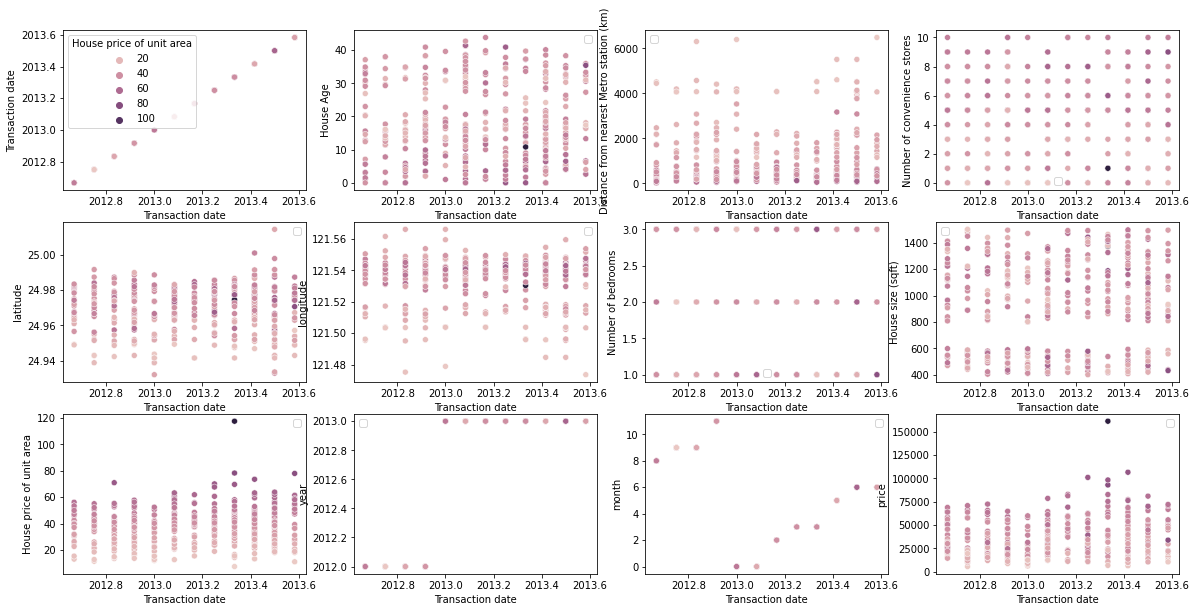

In [13]:
multi_scatplot('Transaction date')

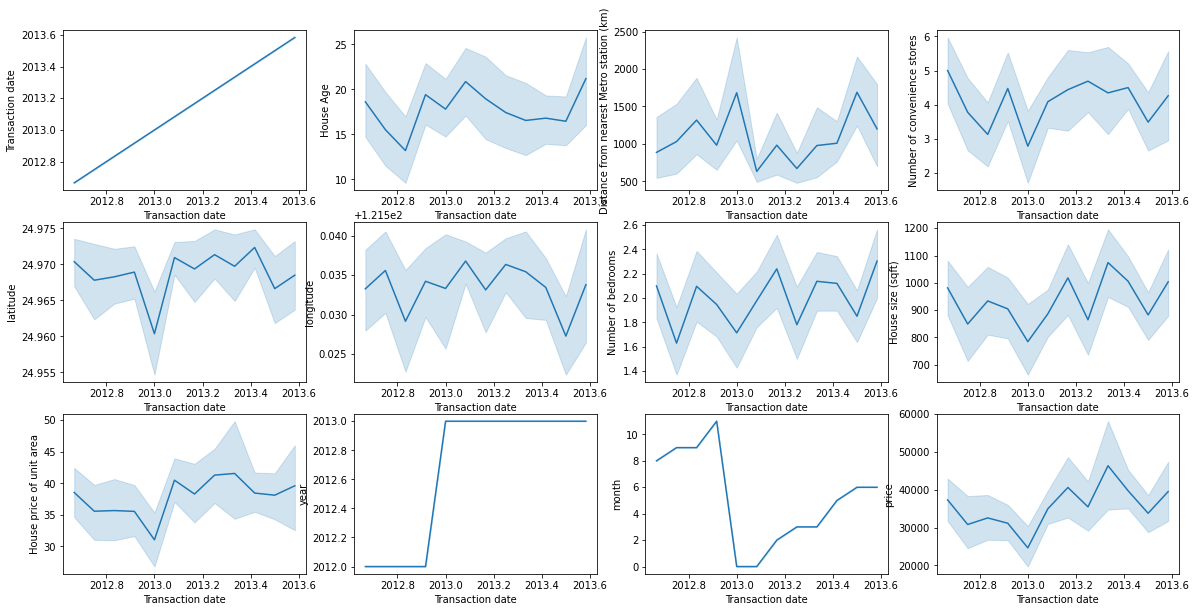

In [14]:
multi_lineplot(df.columns[0])

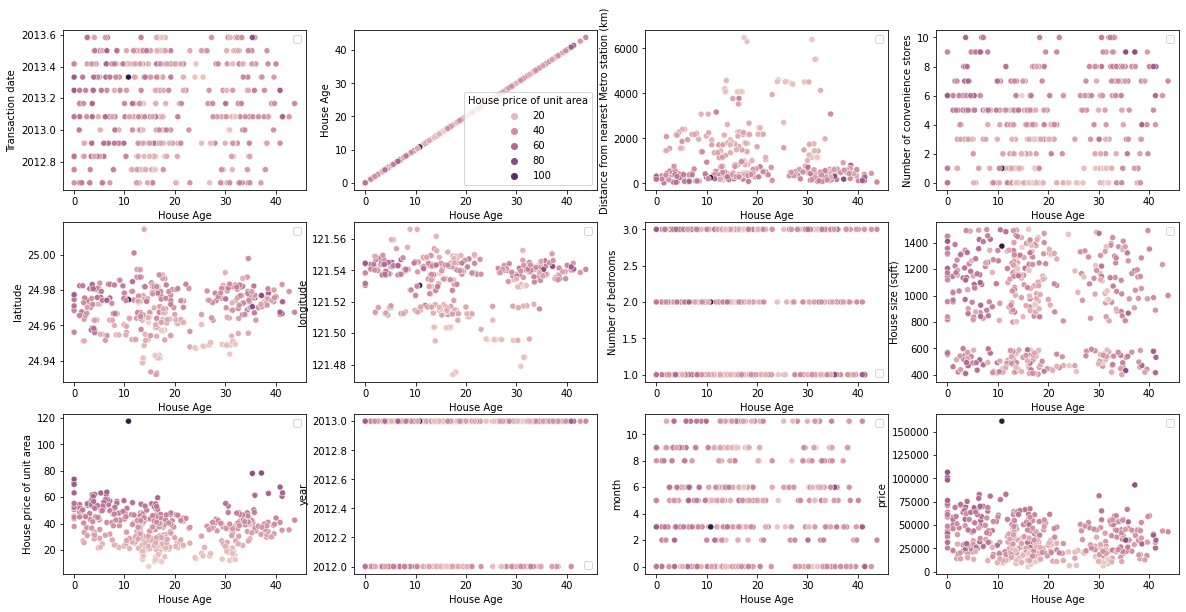

In [15]:
multi_scatplot(df.columns[1])

From above plots we can observe that, less data is present for houses whose age is 20-30 years of age

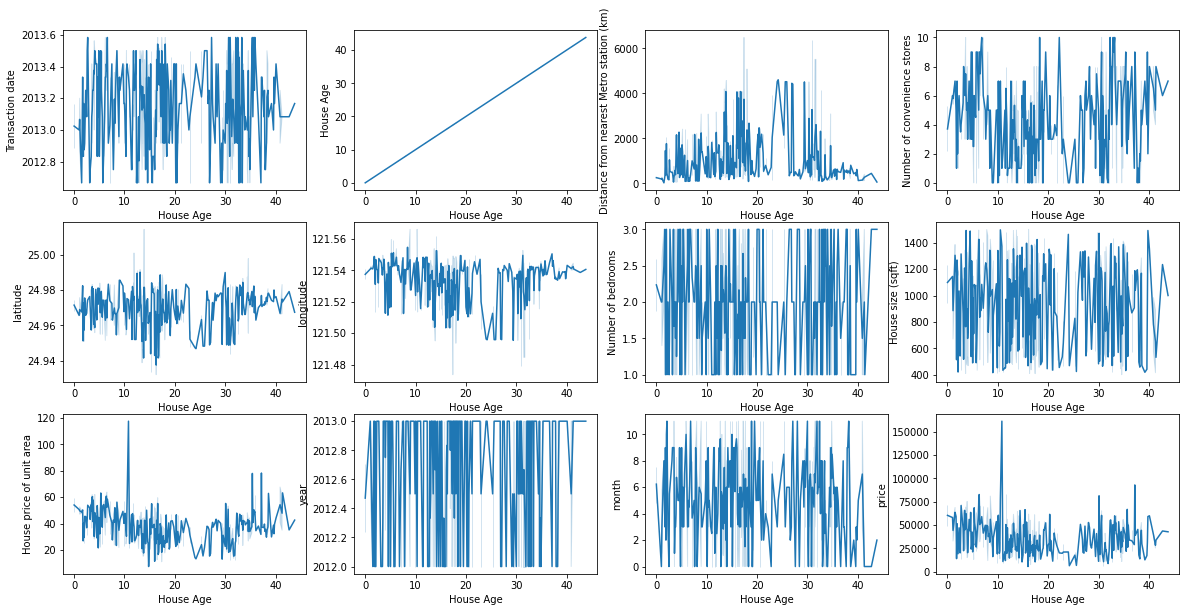

In [16]:
multi_lineplot(df.columns[1])

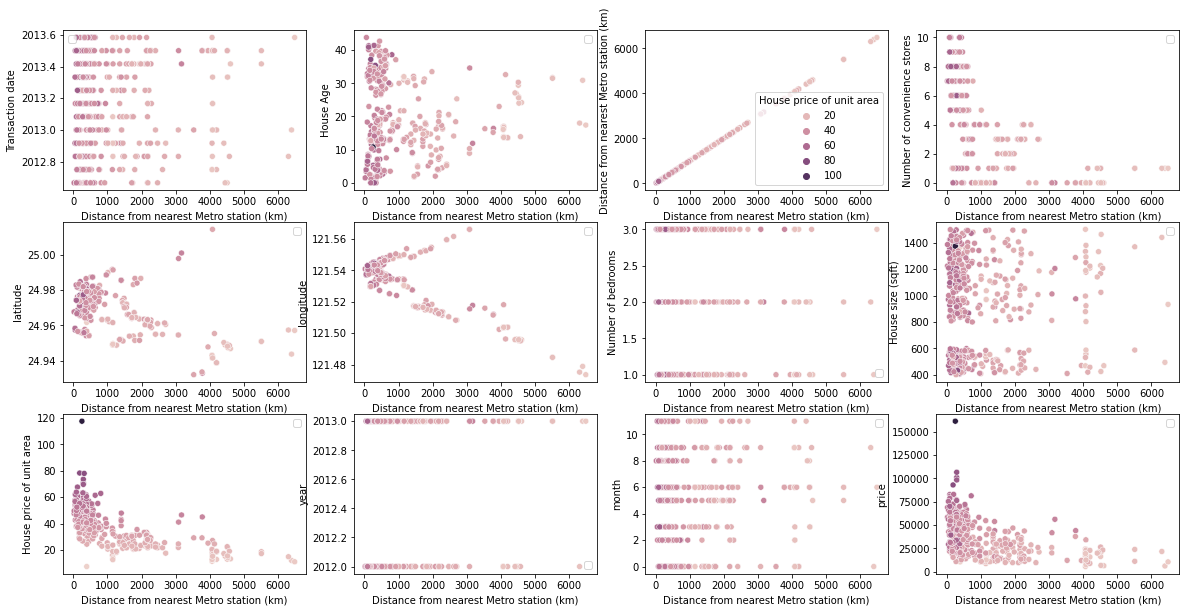

In [17]:
multi_scatplot(df.columns[2])

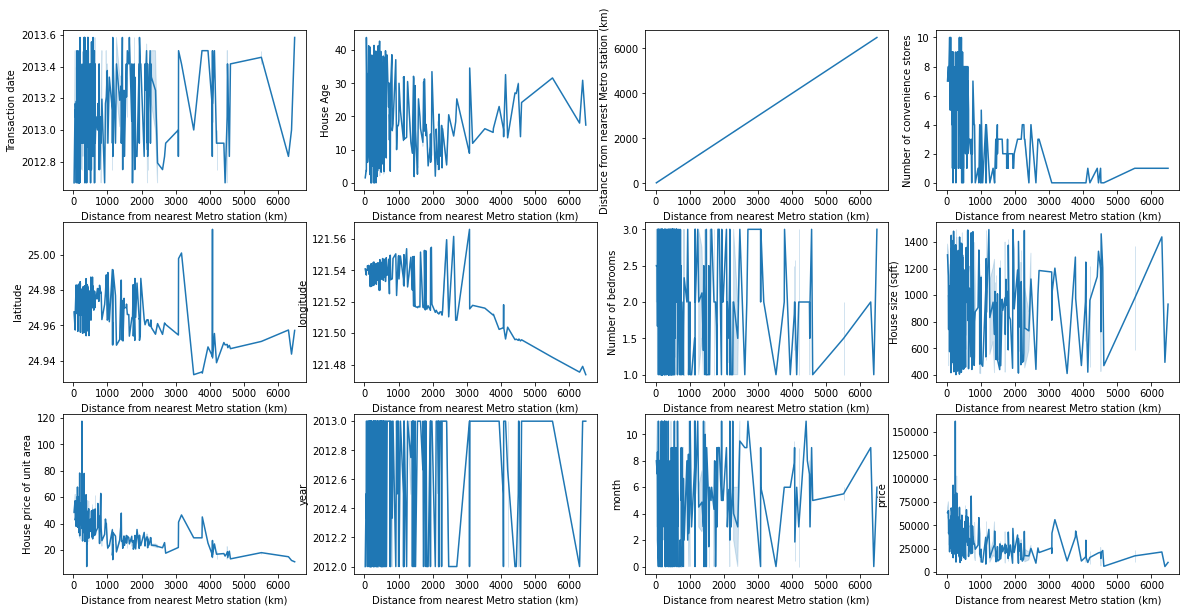

In [18]:
multi_lineplot(df.columns[2])

**Inferences-**


*   Number of convenience stores **decreases** with increasing distance from metro station.
*   House price of unit area **decreases** with increasing distance from metro station.
*   Price **decreases** with increasing distance from metro station.



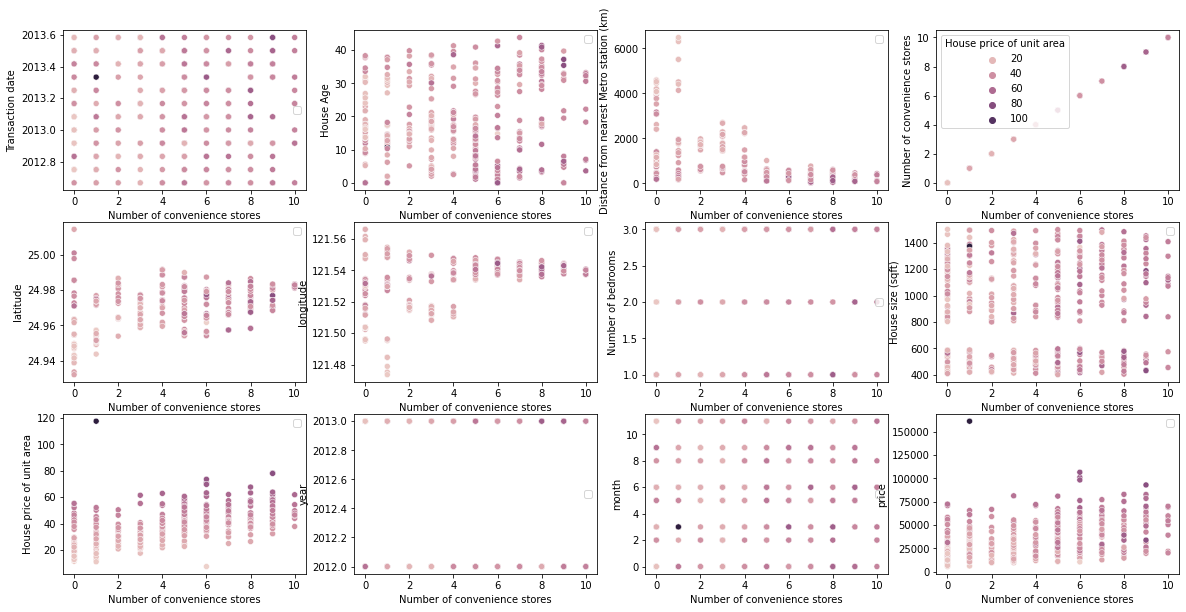

In [19]:
multi_scatplot(df.columns[3])

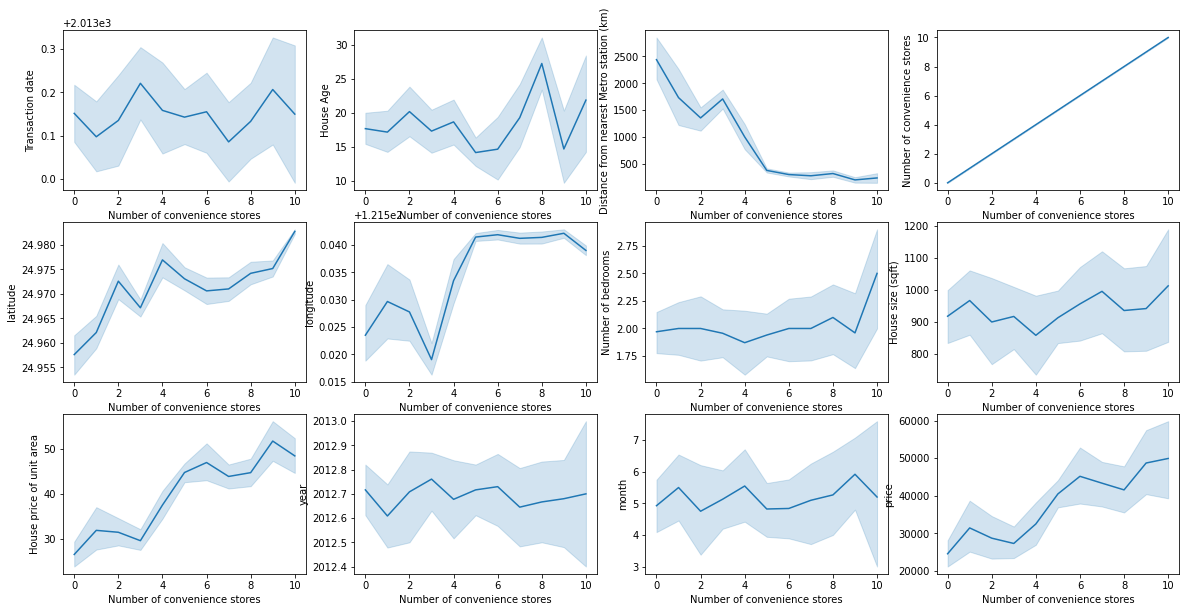

In [20]:
multi_lineplot(df.columns[3])

**Inferences-**


*   Number of convenience store **increases** with increasing Latitude and Longitude.
*   House price of unit area increases with **increasing** Number of convenience stores
*   Price increases with **increasing** number of convenience stores.


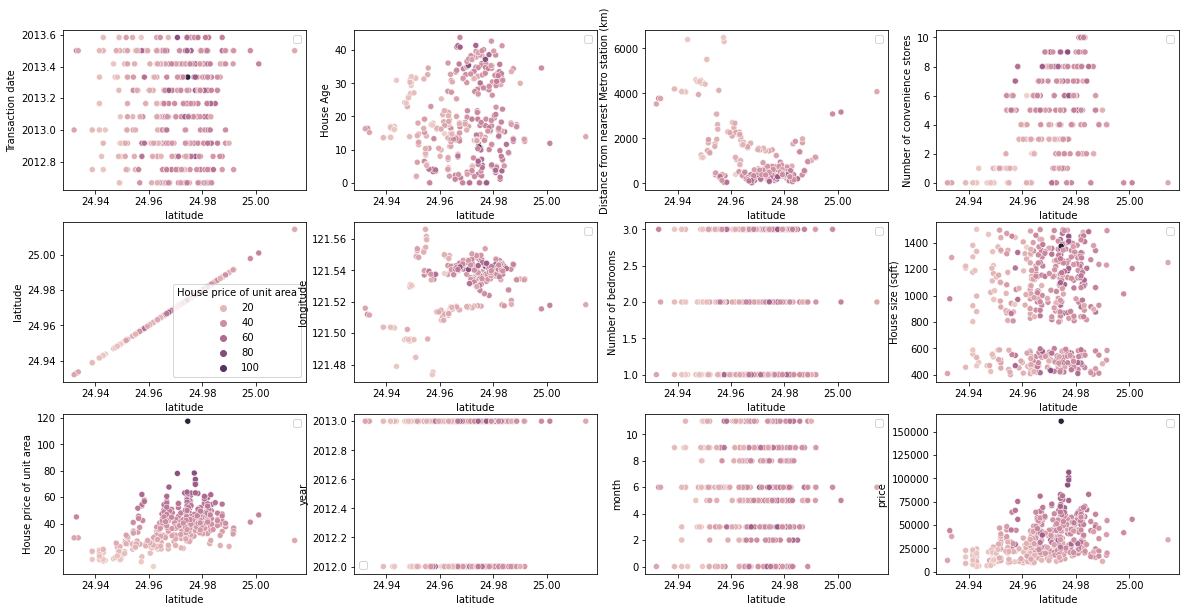

In [21]:
multi_scatplot(df.columns[4])

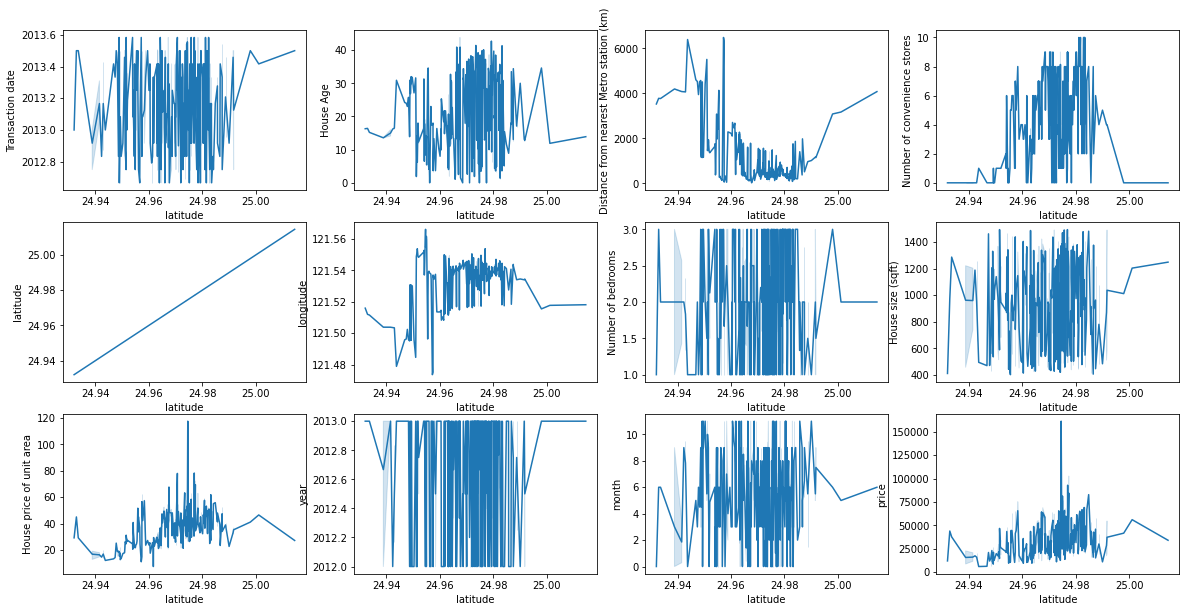

In [22]:
multi_lineplot(df.columns[4])

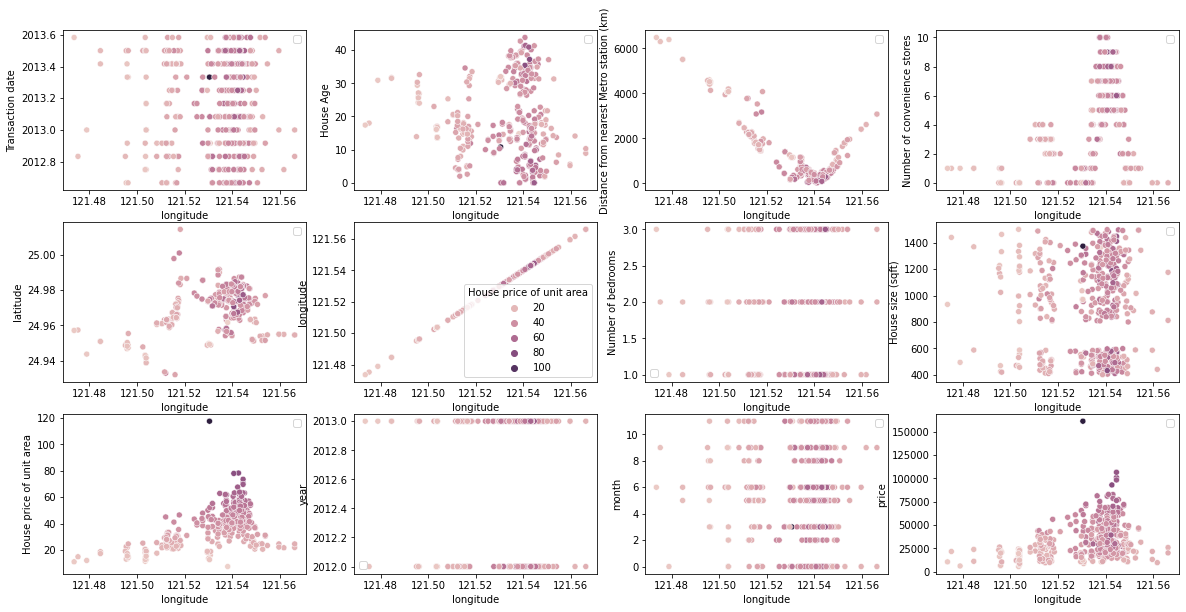

In [23]:
multi_scatplot(df.columns[5])

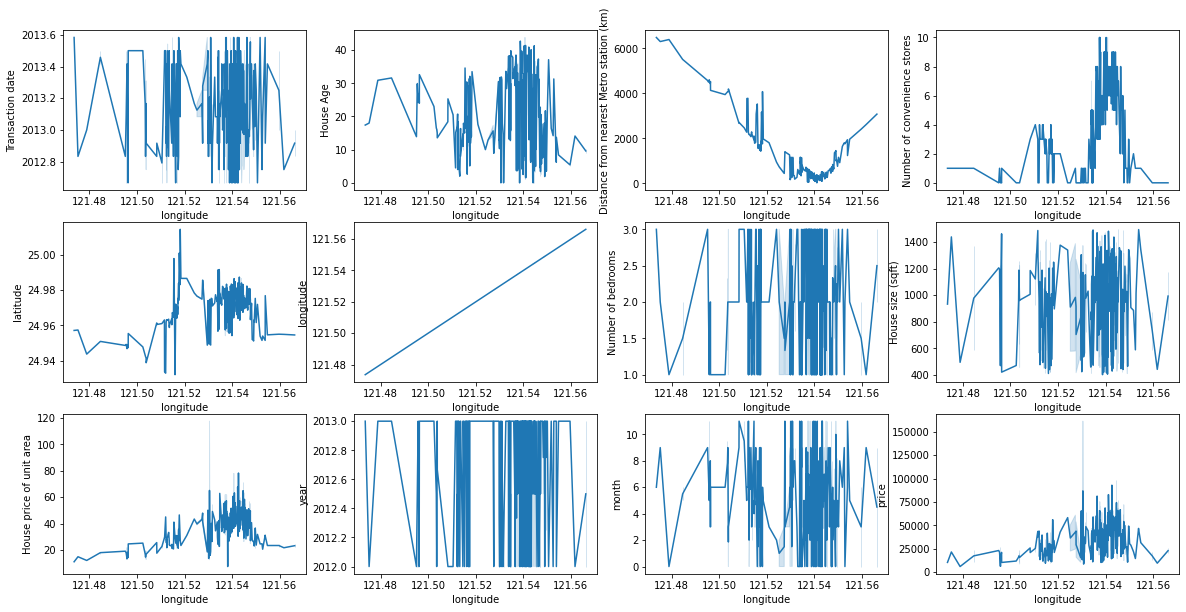

In [24]:
multi_lineplot(df.columns[5])

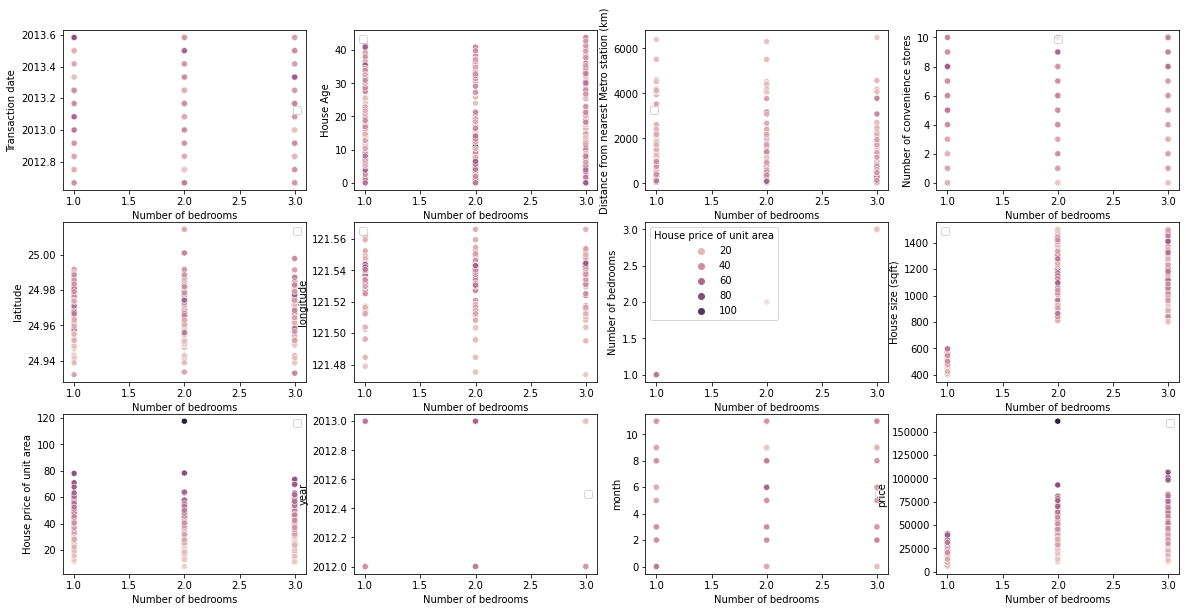

In [25]:
multi_scatplot(df.columns[6])

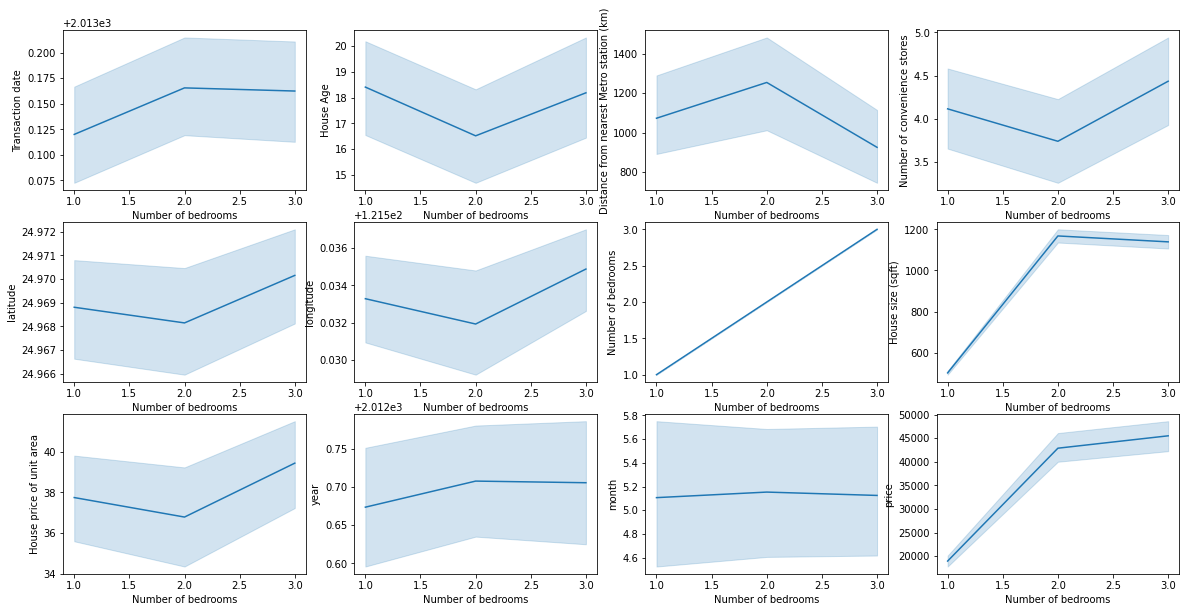

In [26]:
multi_lineplot(df.columns[6])

**Inferences-**


*   House size **increases** with number of bedrooms
*   Price **increases** with number of bedrooms



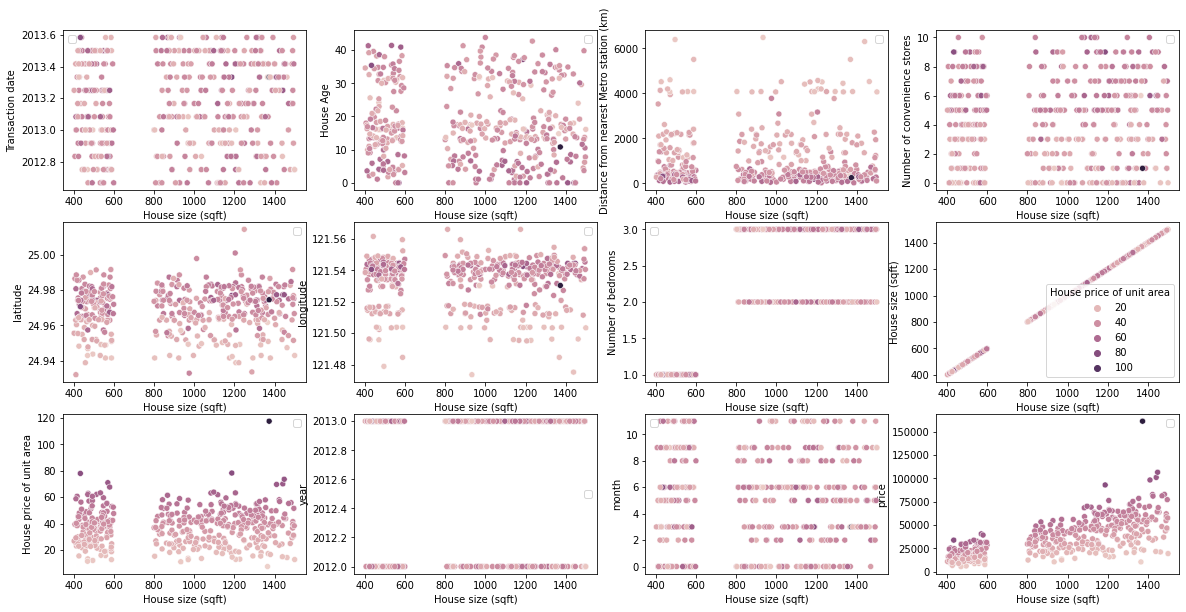

In [27]:
multi_scatplot(df.columns[7])

Dataset contain few houses of house size 600 to 800 sqft.

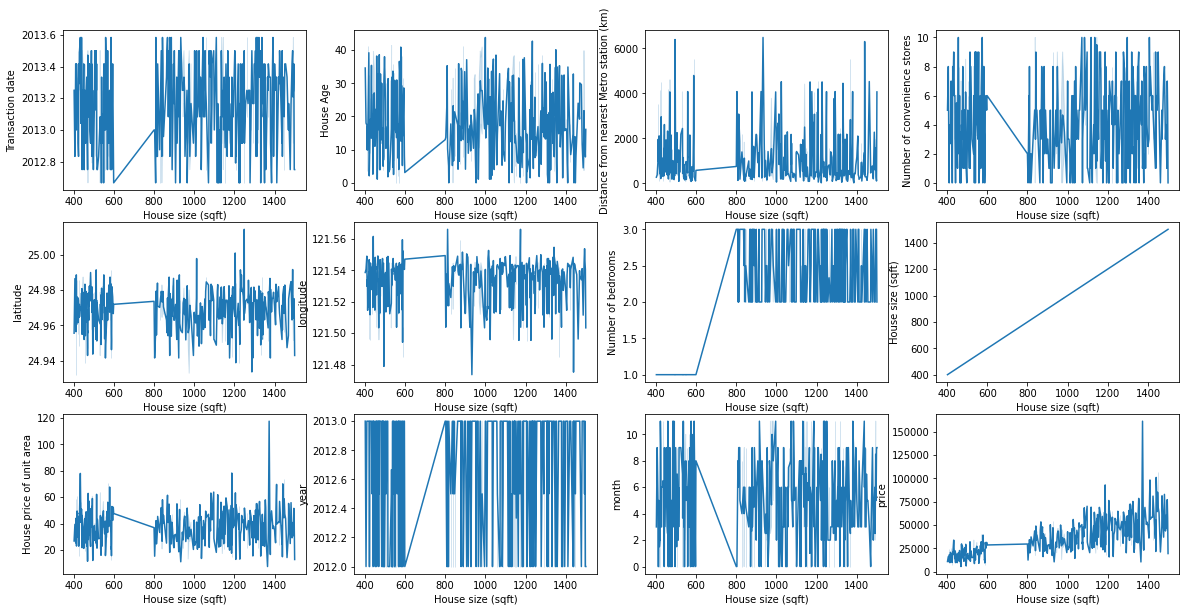

In [28]:
multi_lineplot(df.columns[7])

**Inferences-**


*   Price **increases** with House size (sqft).   



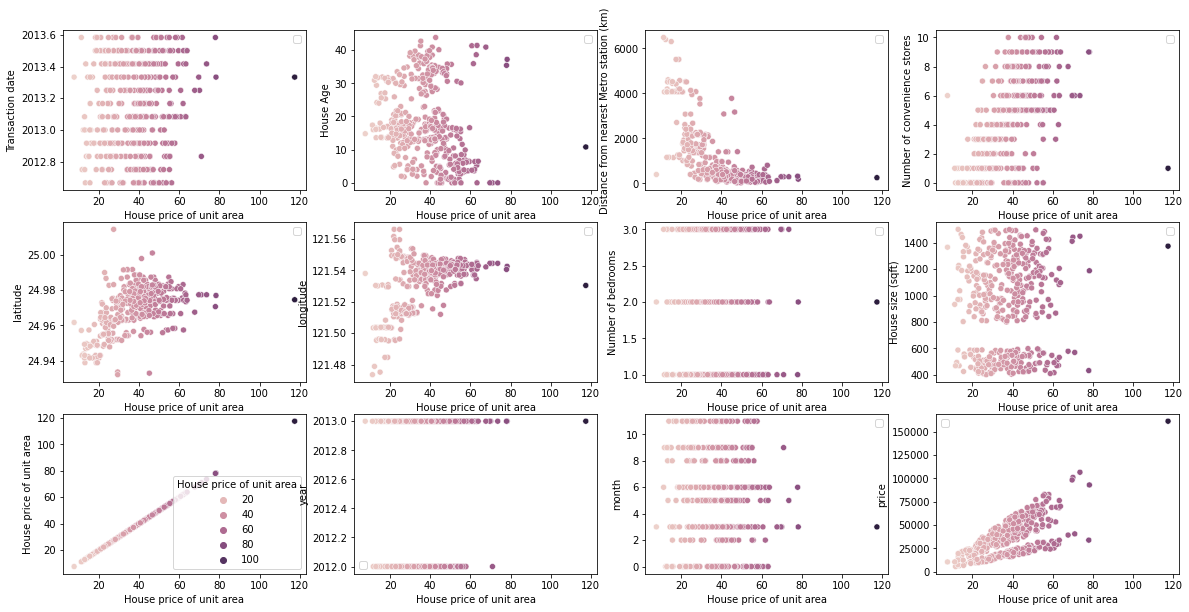

In [29]:
multi_scatplot(df.columns[8])

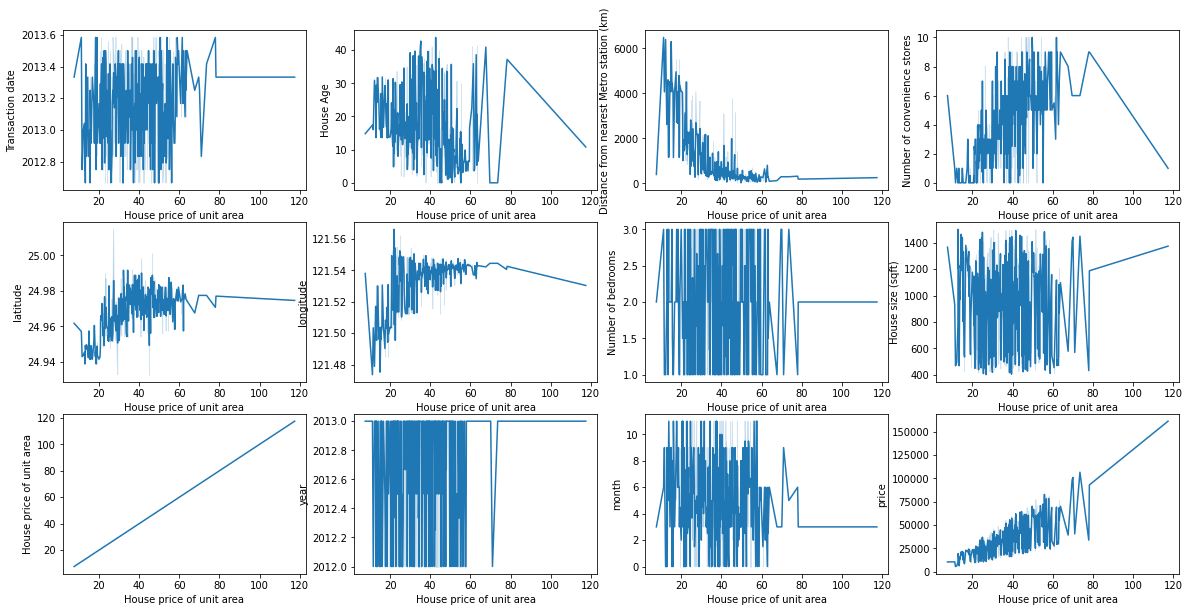

In [30]:
multi_lineplot(df.columns[8])

**Inferences-**


*   House price of unit area **increases** with Latitude and Longitude
*   House price of unit area **decreases** with House Age



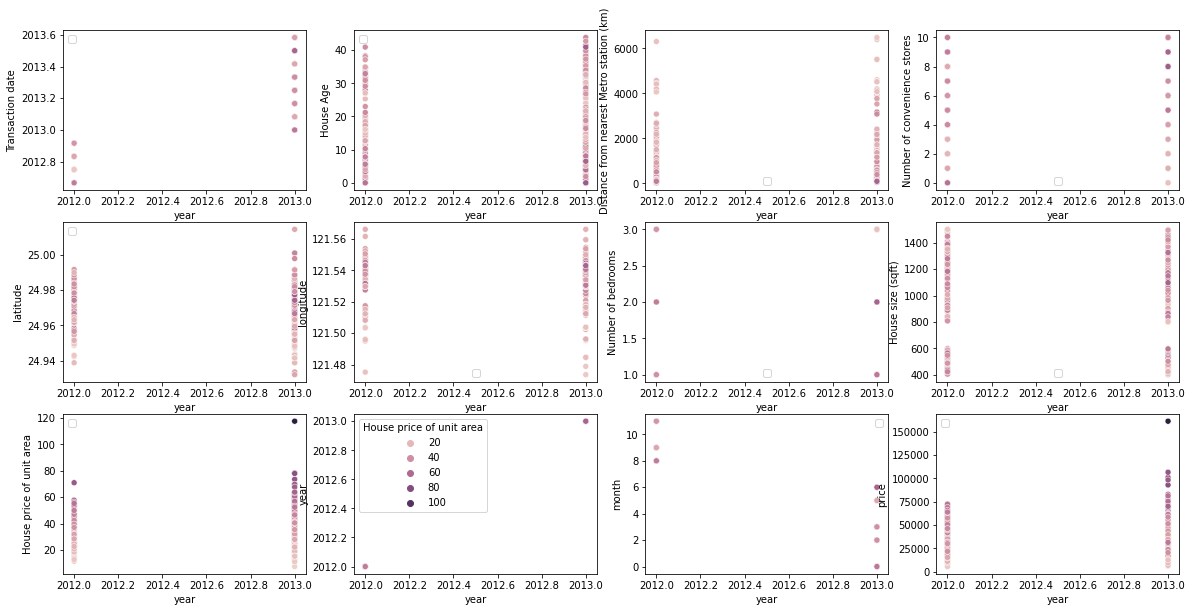

In [31]:
multi_scatplot(df.columns[9])

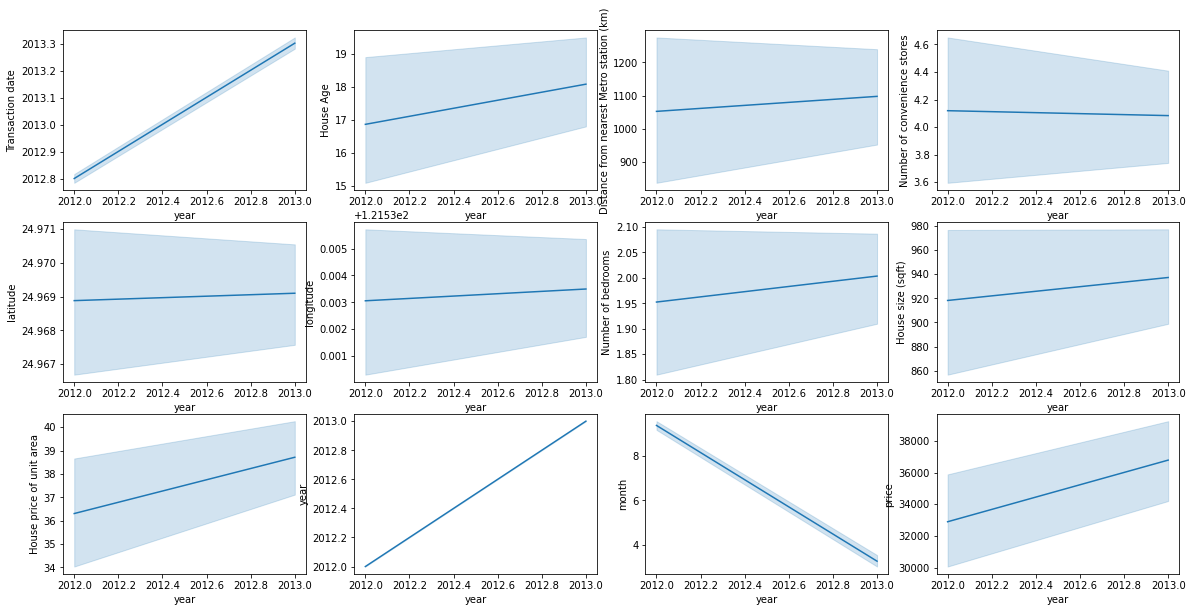

In [32]:
multi_lineplot(df.columns[9])

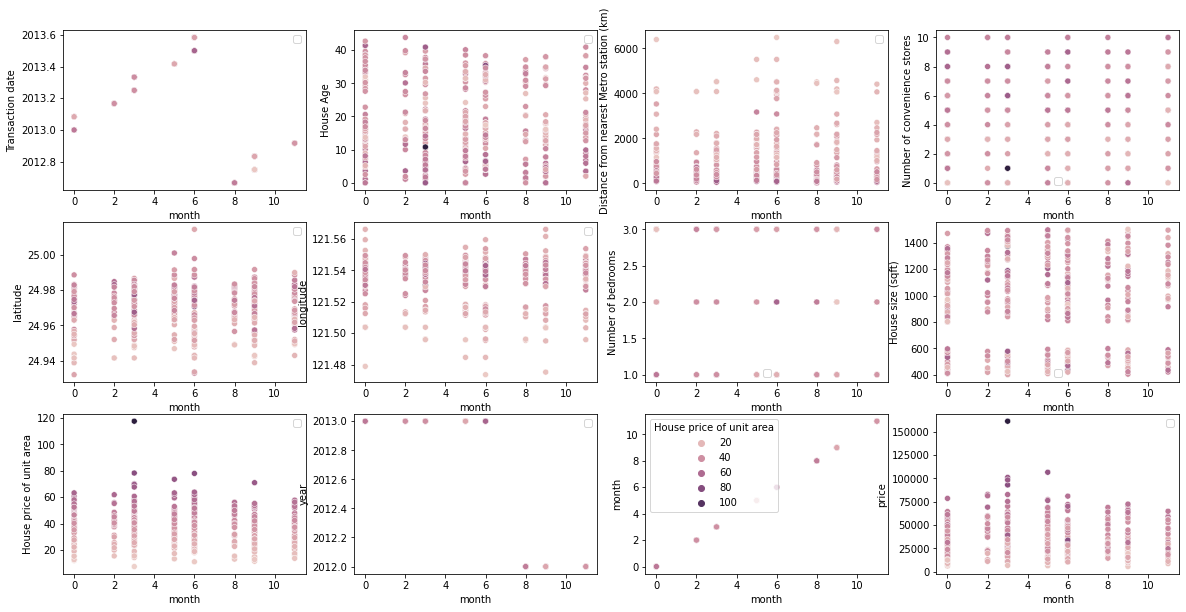

In [33]:
multi_scatplot(df.columns[10])

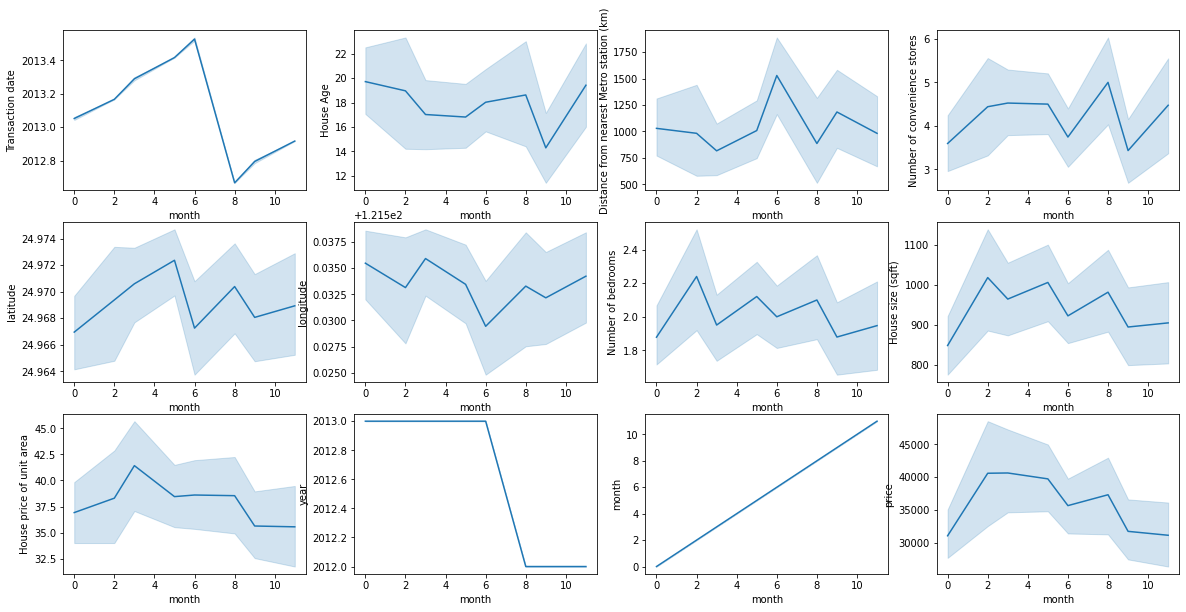

In [34]:
multi_lineplot(df.columns[10])

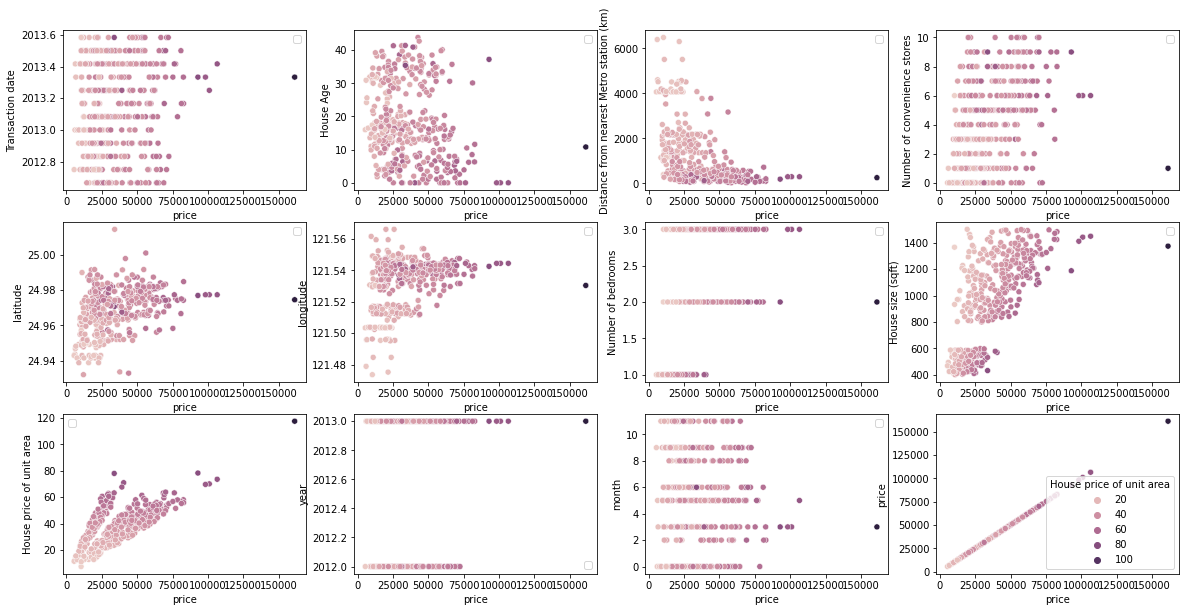

In [35]:
multi_scatplot(df.columns[11])

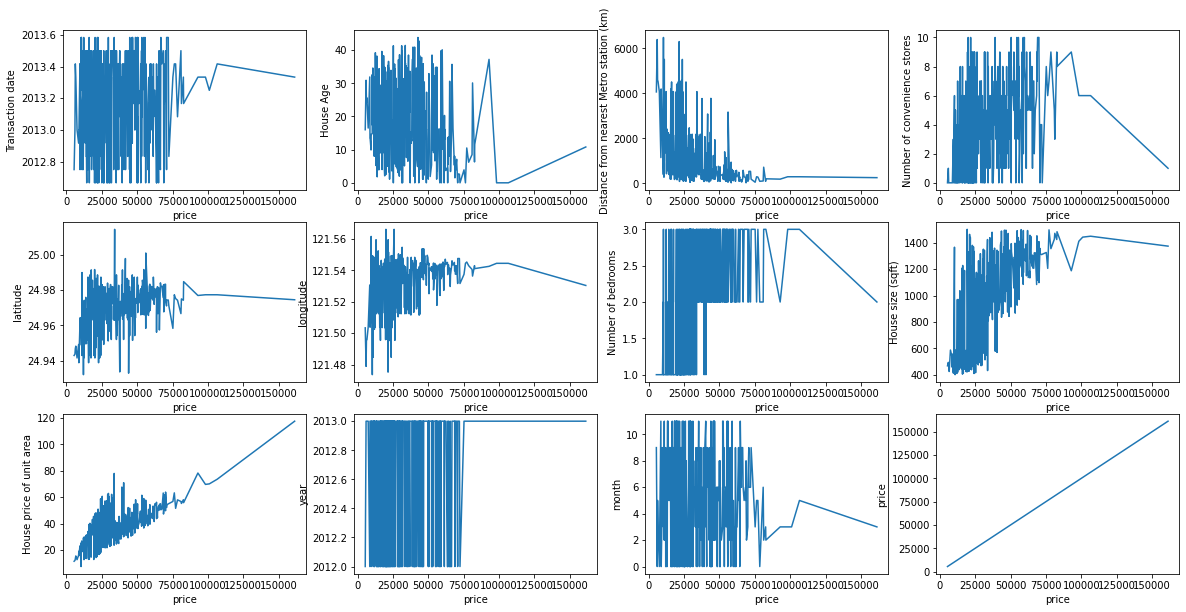

In [36]:
multi_lineplot(df.columns[11])

In [38]:
np.sort((df['House price of unit area']).apply(lambda x: math.floor(x)).unique())

array([  7,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  67,  69,  70,  71,  73,  78, 117])

In [39]:
map3 = folium.Map(location=[24.98298, 121.54024], zoom_start=14)
fg = folium.FeatureGroup(name='shackLab2')

for i in range(df.shape[0]):
  lctn = [df.iat[i, 4], df.iat[i, 5]]
  price = df.iat[i, 8]
  if price<10:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='yellow'), popup=price))
  elif price>=10 and price<20:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='green'), popup=price))
  elif price>=20 and price<30:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='blue'), popup=price))
  elif price>=30 and price<40:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='black'), popup=price))
  elif price>=40 and price<50:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='red'), popup=price))
  elif price>=50 and price<60:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='pink'), popup=price))
  elif price>=60 and price<70:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='brown'), popup=price))
  elif price>=70 and price<80:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='orange'), popup=price))
  else:
    fg.add_child(folium.Marker(location=lctn, icon=folium.Icon(color='grey'), popup=price))

map3.add_child(fg)
map3

The given area is from TAIWAN.

# Feature Selection

In [40]:
df_clean = df.drop(['price', 'year', 'month', 'Distance from nearest Metro station (km)'], axis=1)

In [41]:
df_clean.head()

Transaction date  House Age  Number of convenience stores  latitude  \
0       2012.916667       32.0                            10  24.98298   
1       2012.916667       19.5                             9  24.98034   
2       2013.583333       13.3                             5  24.98746   
3       2013.500000       13.3                             5  24.98746   
4       2012.833333        5.0                             5  24.97937   

   longitude  Number of bedrooms  House size (sqft)  House price of unit area  
0  121.54024                   1                575                      37.9  
1  121.53951                   2               1240                      42.2  
2  121.54391                   3               1060                      47.3  
3  121.54391                   2                875                      54.8  
4  121.54245                   1                491                      43.1

In [42]:
x = df_clean.drop('House price of unit area', axis=1)
y = df_clean['House price of unit area']

In [43]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2)

In [44]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Models

In [45]:
lin_reg = LinearRegression()
dec_reg = DecisionTreeRegressor()
ran_reg = RandomForestRegressor()
xgb_reg = xgb.XGBRegressor()

In [46]:
models = [lin_reg, dec_reg, ran_reg, xgb_reg]

In [47]:
def results(models, xtrain=xtrain, ytrain=ytrain, xtest=xtest, ytest=ytest):
  mse_list = []
  mae_list = []
  for model in models:
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    mae = mean_absolute_error(ytest, ypred)
    mse_list.append(mse)
    mae_list.append(mae)
  
  dic = {
      'model': [str(model).split('(')[0] for model in models],
      'mse': mse_list,
      'mae': mae_list,
  }

  result = pd.DataFrame(data=dic)
  return result

In [48]:
result_raw = results(models)
result_raw

[18:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


model         mse       mae
0       LinearRegression  169.412392  8.081557
1  DecisionTreeRegressor  159.202289  7.379518
2  RandomForestRegressor  123.344229  5.841916
3           XGBRegressor  124.476546  6.249524

In [49]:
param_grid_dec = {
    'criterion': ['squared_error', 'friedman_mse', 'friedman_mse', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 10, 2),
    'min_samples_split': range(2, 10, 2),
    'min_samples_leaf': range(1, 10, 2)
}
param_grid_ran = {
    'n_estimators': [20, 50, 100, 150, 200, 300],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': range(2, 10, 2),
    'min_samples_split': range(2, 10, 2),
    'min_samples_leaf': range(1, 10, 2)
}
param_grid_xgb = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': np.arange(0.01, 0.2, 0.01),
    'max_depth': range(2, 10, 2),
}

In [50]:
models_search = [dec_reg, ran_reg, xgb_reg]
params = [param_grid_dec, param_grid_ran, param_grid_xgb]
best_params = []
for model, param in list(zip(models_search, params)):
  print(f'\nProcessing {model}....')
  grid_search = GridSearchCV(estimator=model, param_grid=param, cv=3, n_jobs=-1, verbose=2)
  grid_search.fit(xtrain, ytrain)
  best_params.append(grid_search.best_params_)


Processing DecisionTreeRegressor()....
Fitting 3 folds for each of 640 candidates, totalling 1920 fits

Processing RandomForestRegressor()....
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits

Processing XGBRegressor()....
Fitting 3 folds for each of 228 candidates, totalling 684 fits
[19:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
best_params

[{'criterion': 'squared_error',
  'max_depth': 6,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'splitter': 'random'},
 {'criterion': 'absolute_error',
  'max_depth': 8,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 20},
 {'booster': 'dart', 'eta': 0.01, 'max_depth': 2}]

In [52]:
dec_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=5, min_samples_split=6, splitter='random')
ran_reg = RandomForestRegressor(criterion='squared_error', max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
xgb_reg = xgb.XGBRegressor(booster='gbtree', eta=0.01, max_depth=2)
models = [dec_reg, ran_reg, xgb_reg]

In [53]:
result_tune = results(models)
result_tune

[19:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


model         mse       mae
0  DecisionTreeRegressor  137.433724  6.944460
1  RandomForestRegressor  123.053531  5.889586
2           XGBRegressor  130.761081  6.356591

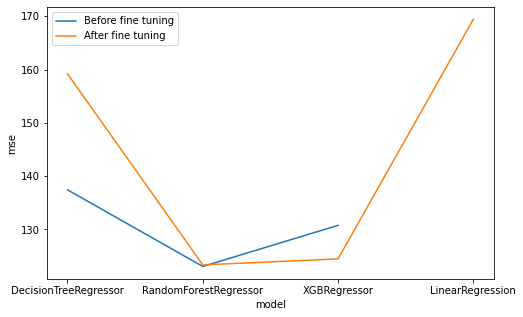

In [54]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='model', y='mse', data=result_tune)
sns.lineplot(x='model', y='mse', data=result_raw)
plt.legend(['Before fine tuning', 'After fine tuning'])

After fine tuning the mse scores of the model didn't increased much

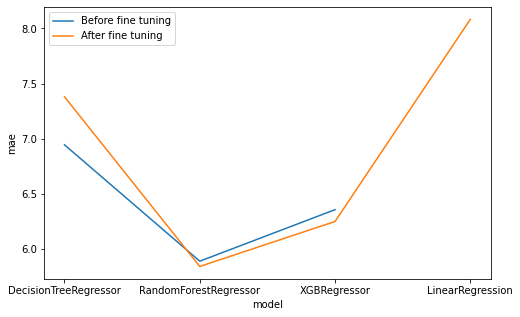

In [55]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='model', y='mae', data=result_tune)
sns.lineplot(x='model', y='mae', data=result_raw)
plt.legend(['Before fine tuning', 'After fine tuning'])

mae score of decision tree has decreased by 1.5.

However, the performance of Random forest is best in both the cases.
So I suggest working with Random Forest model

Random Forest and XGBoost are both ensemble models which give good performance in comparison to normal models.
Random forest uses bagging technique in which multiple models are trained parallely, while XGBoost uses boosting technique in which models are trained sequentially. Both the approaches makes model robust.

### Finalised Model - Random Forest